In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import scipy.linalg

plt.rc("text", usetex=False)
plt.rc("font", family = "serif",size=14)
plt.rc("figure",figsize=(12,10))
%config InlineBackend.figure_format = 'retina'

Here we analyze the 4-vertex graph with a single cycle, $K_4$.

<img src="k4.png" width="400" height="200">

In [2]:
def round_sig(x, sig_figs=4):
    """
    Rounds a number to a given number of significant figures.
    
    Parameters
    ----------
    x : float
        number to round
        
    sig_figs : integer (default=4)
        number of sig figs to round to
        
    Returns
    ----------
    x rounded to the desired number of significant figures
    """
    if x == 0:
        return 0.0
    return round(x, sig_figs - int(np.floor(np.log10(abs(x)))) - 1)

def eq_params_k4():
    """
    Samples equilibrium parameter sets for a 4-state single-cycle graph
    (k12, k23, k34, k41) and (k21, k32, k43, k14), ensuring zero cycle affinity.

    Returns
    -------
    labels_f : list of 4 floats
        Forward rates: [k12, k23, k34, k41]
    labels_r : list of 4 floats
        Reverse rates: [k21, k32, k43, k14]
    """

    # Sample 7 of the 8 parameters freely
    k12 = round_sig(10 ** np.random.uniform(-3, 3), sig_figs=4)
    k23 = round_sig(10 ** np.random.uniform(-3, 3), sig_figs=4)
    k34 = round_sig(10 ** np.random.uniform(-3, 3), sig_figs=4)
    k41 = round_sig(10 ** np.random.uniform(-3, 3), sig_figs=4)

    k21 = round_sig(10 ** np.random.uniform(-3, 3), sig_figs=4)
    k32 = round_sig(10 ** np.random.uniform(-3, 3), sig_figs=4)
    k43 = round_sig(10 ** np.random.uniform(-3, 3), sig_figs=4)

    # Solve for k14 to make the cycle affinity zero
    # A(C) = log[(k12 k23 k34 k41)/(k21 k32 k43 k14)] = 0 → solve for k14
    k14 = (k12 * k23 * k34 * k41) / (k21 * k32 * k43)

    labels_f = [k12, k23, k34, k41]
    labels_r = [k21, k32, k43, k14]

    return labels_f, labels_r

In [3]:
labels_f, labels_r = [1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0] #eq_params_k4()
print(labels_f)
print(labels_r)

aff = np.log(np.prod(labels_f)/np.prod(labels_r))
print(aff)

[1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0]
0.0


In [4]:
def spec_k4(lap):
    eigvals, eigvecs = scipy.linalg.eig(lap)
    v = eigvecs[:, np.argmin(np.abs(eigvals))].real #np.array([eigvecs[:,np.argmin(np.abs(eigvals))].real/sum(eigvecs[:,np.argmin(np.abs(eigvals))].real)])
    pi = v / v.sum()
    return pi

In [5]:
def lap_k4(labels_f, labels_r):
    # labels_f = k12, k23, k34, k41
    k12, k23, k34, k41 = labels_f[0], labels_f[1], labels_f[2], labels_f[3]
    # labels_r = k21, k32, k43, k14
    k21, k32, k43, k14 = labels_r[0], labels_r[1], labels_r[2], labels_r[3]
    
    lap = np.array([[-k14-k12, k21, 0, k41], [k12, -k21-k23, k32, 0], [0, k23, -k32-k34, k43], [k14, 0, k34, -k41-k43]],dtype=float)
    
    return lap

In [6]:
lap = lap_k4(labels_f, labels_r)
pi = spec_k4(lap)

print("Laplacian:\n", lap)
print("---")
print("Stationary distribution:\n", pi)
print(np.sum(pi))
print("---")
print("∆(u*(G)):\n", np.diag(pi))
print("---")
print(np.diag(pi).shape)

Laplacian:
 [[-2.  1.  0.  1.]
 [ 1. -2.  1.  0.]
 [ 0.  1. -2.  1.]
 [ 1.  0.  1. -2.]]
---
Stationary distribution:
 [0.25 0.25 0.25 0.25]
1.0
---
∆(u*(G)):
 [[0.25 0.   0.   0.  ]
 [0.   0.25 0.   0.  ]
 [0.   0.   0.25 0.  ]
 [0.   0.   0.   0.25]]
---
(4, 4)


In [7]:
signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 1000, num=500)

In [8]:
def autocorrelation_analytical(observable,L,tau_n,alpha=1,beta=3):
    """
    Calculates the analytical solution for forward and reverse higher-order autocorrelation functions for a particular Laplacian matrix
    
    Parameters
    ----------
    observable : 1D array
        possible values of observable (which is a state function on the Markov process)
    L : NxN array
        column-based Laplacian matrix of linear framework graph with N vertices
    tau_n : 1D array
        range of intervals between values of observable taken by system
    alpha : scalar
        exponent applied to observable
    beta : scalar
        exponent applied to transpose of observable
    
    Returns
    -------
    t : 1D array
        forward autocorrelation function values
    t_rev : 1D array
        reverse autocorrelation function values
    
    """
    f = np.array([observable],dtype=np.float128)
    fstar = f.T
    
    # calculate the stationary distribution of the Markov process
    eigvals, eigvecs = scipy.linalg.eig(L)
    pi = np.array([eigvecs[:,np.argmin(np.abs(eigvals))].real/sum(eigvecs[:,np.argmin(np.abs(eigvals))].real)]).T
    
    # initialize forward and reverse autocorrelation function arrays
    t = np.zeros(len(tau_n),dtype=np.float128)
    t_rev = np.zeros(len(tau_n),dtype=np.float128)
    
    list_result = list(map(lambda i: scipy.linalg.expm(L*i), tau_n))
    
    # populate arrays with analytical solution to autocorrelation function
    for i in range(len(tau_n)):
        t[i] = f**alpha @ list_result[i] @(fstar ** beta * pi)
        t_rev[i] = f**beta @ list_result[i] @(fstar ** alpha * pi)
        
    return t, t_rev

In [9]:
a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)

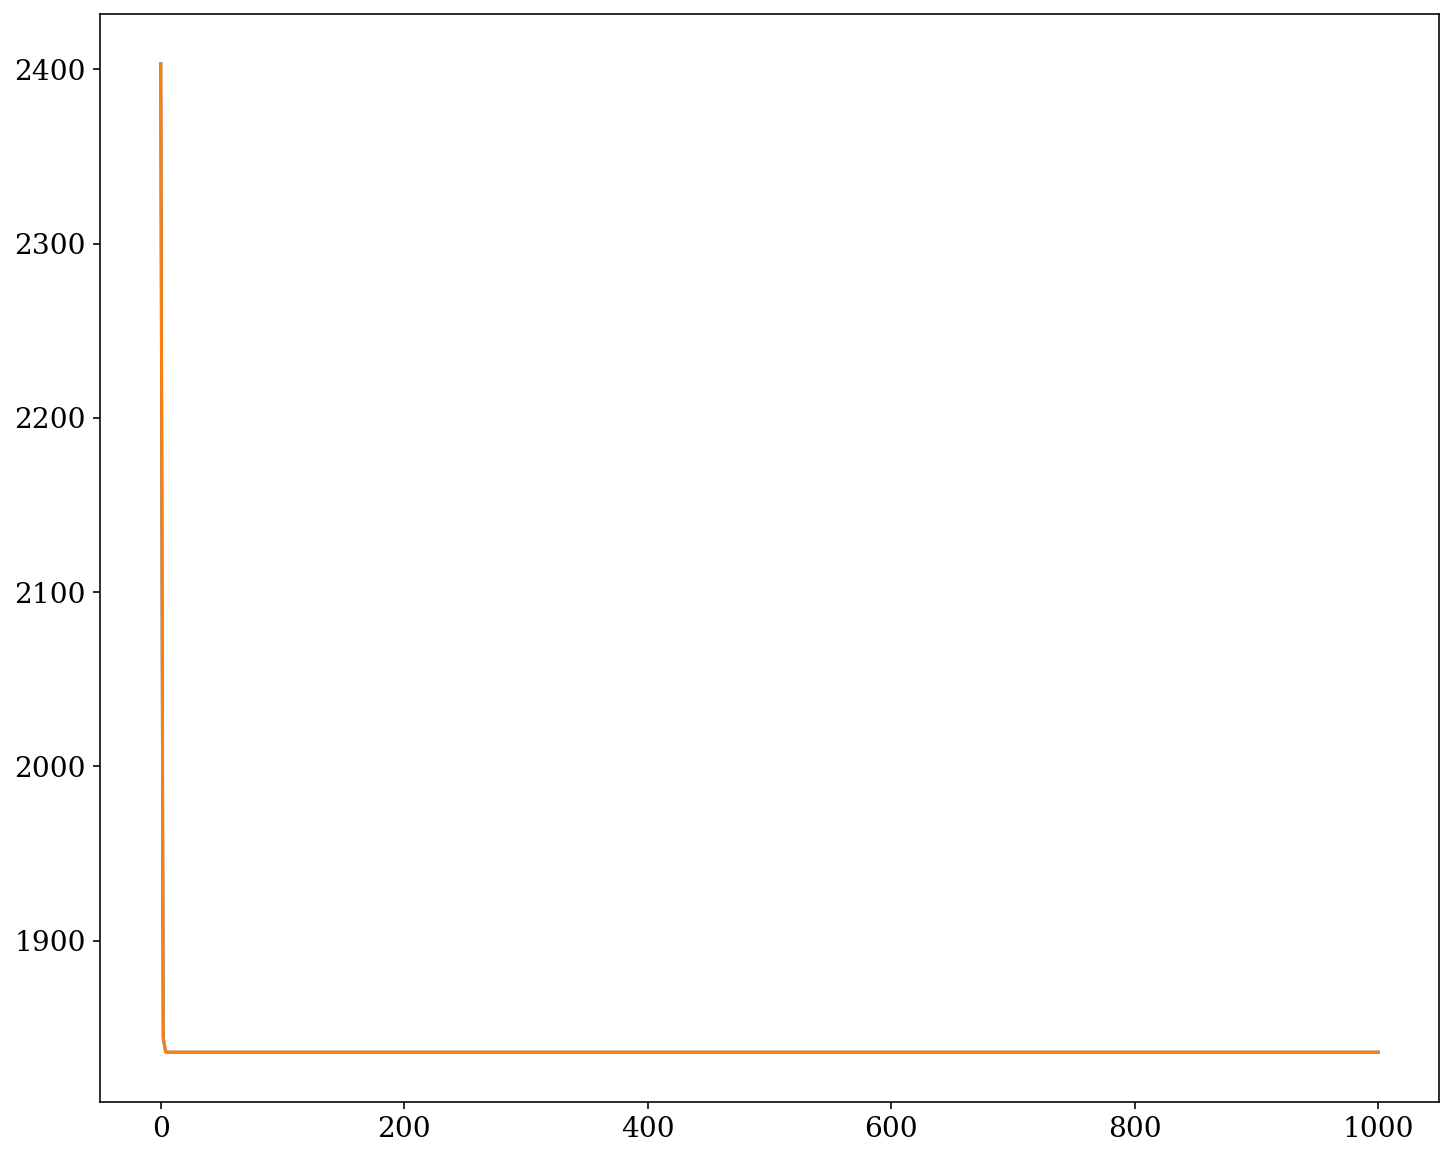

In [10]:
plt.plot(tau,a13)
plt.plot(tau,a31)

In [11]:
area = np.abs(np.trapz(a13)-np.trapz(a31))
print(area)

1.1368683772161602974e-12


Parameter set 1: all-ones parameter set

In [12]:
# k23

# eq params
labels_f = [1.0, 1.0, 1.0, 1.0]
labels_r = [1.0, 1.0, 1.0, 1.0]

# autocorr settings
signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 200, num=1000)

# arrays for tracking aff, area, and eigs
N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N, dtype=float)
eigvals_all_r = np.zeros((N, 4), dtype=np.float128)
eigvals_all_c = np.zeros((N, 4), dtype=np.float128)

# edge to perturb
edge_idx = 1
perturb_edge = labels_f[edge_idx] # labels_f[1] = k23

for i in tqdm(range(0,N)):
    
    labels_f[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
    areas[i] = np.abs(np.trapz(a13)-np.trapz(a31))
    
    # Track eigenvalues (real part)
    eigvals = scipy.linalg.eigvals(lap)
    eigvals_all_r[i, :] = np.sort(eigvals.real)
    eigvals_all_c[i, :] = np.sort(eigvals.imag)
    
    perturb_edge *= 1.01

np.savez(f"steinberg_edge_{edge_idx}_allones.npz", affinities=affinities, areas=areas)

100%|███████████████████████████████████████| 2000/2000 [10:56<00:00,  3.05it/s]


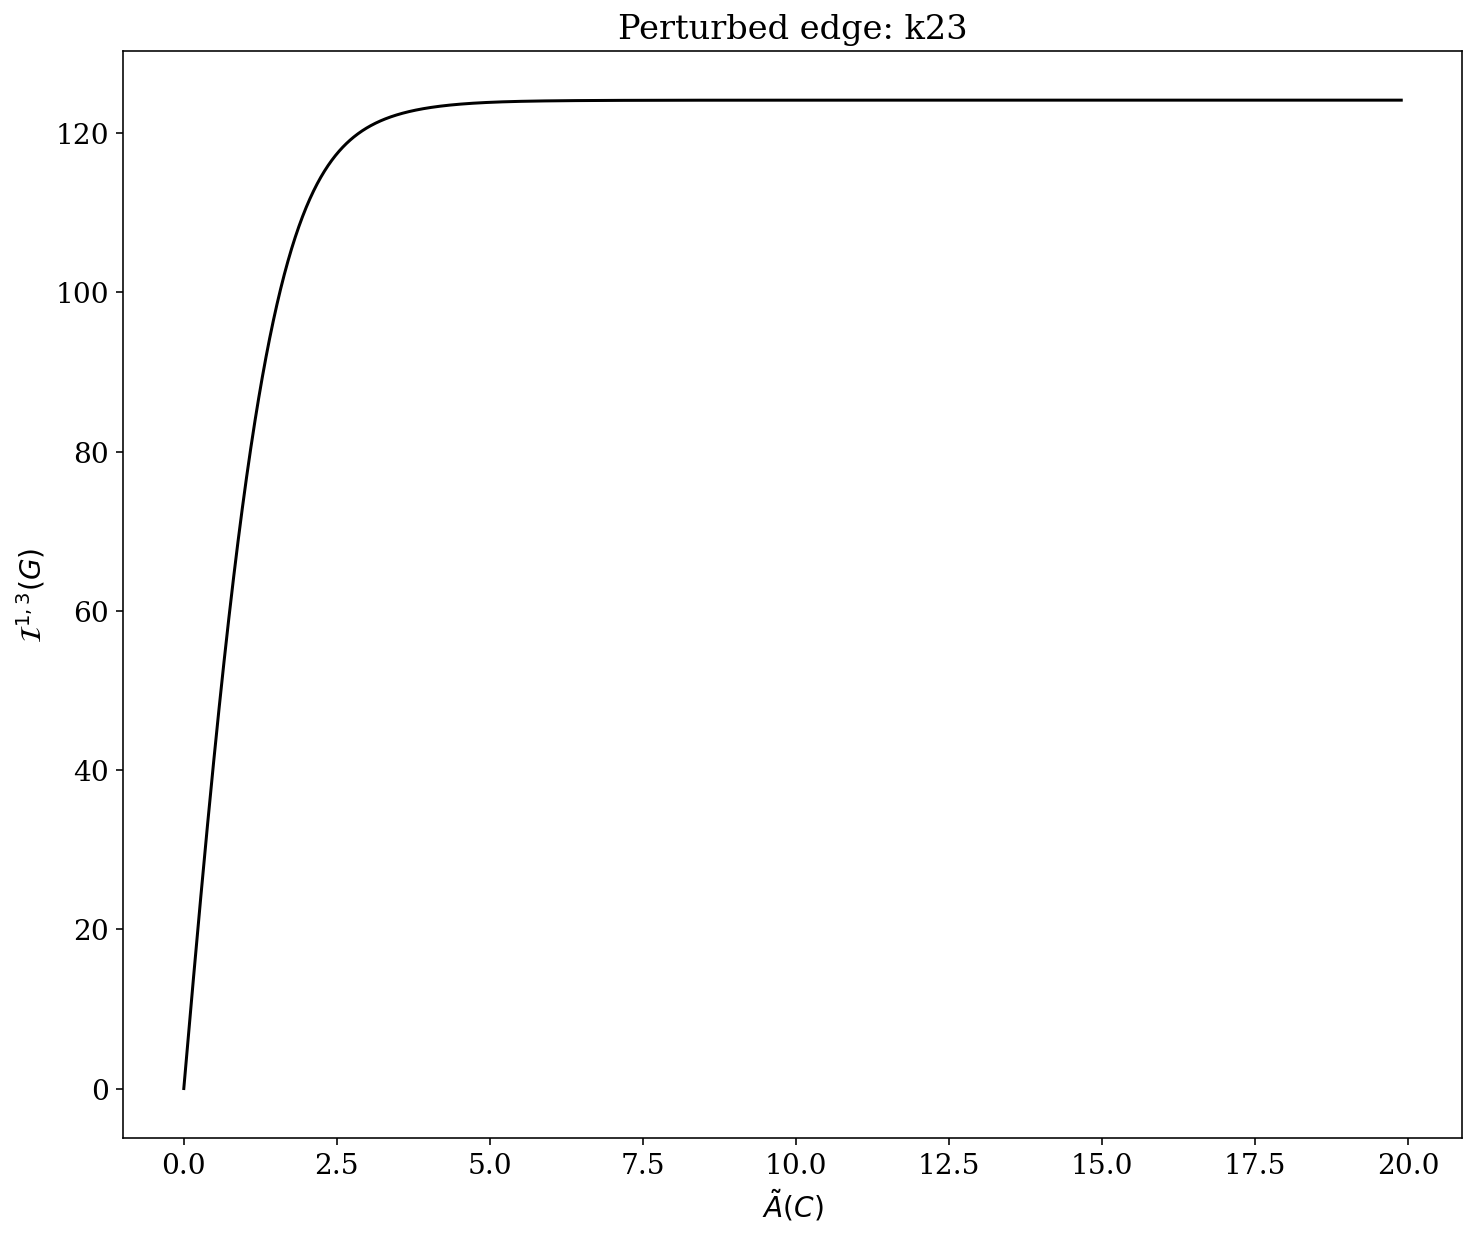

In [13]:
edge_map = {
    0: (1, 2),
    1: (2, 3),
    2: (3, 4),
    3: (4, 1)
}
src, tgt = edge_map[edge_idx]

plt.figure()
plt.plot(affinities, areas, color='black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.title(f"Perturbed edge: k{src}{tgt}")
plt.savefig(f"steinberg_curve_edge_{edge_idx}_allones.png", dpi=300)
plt.show()

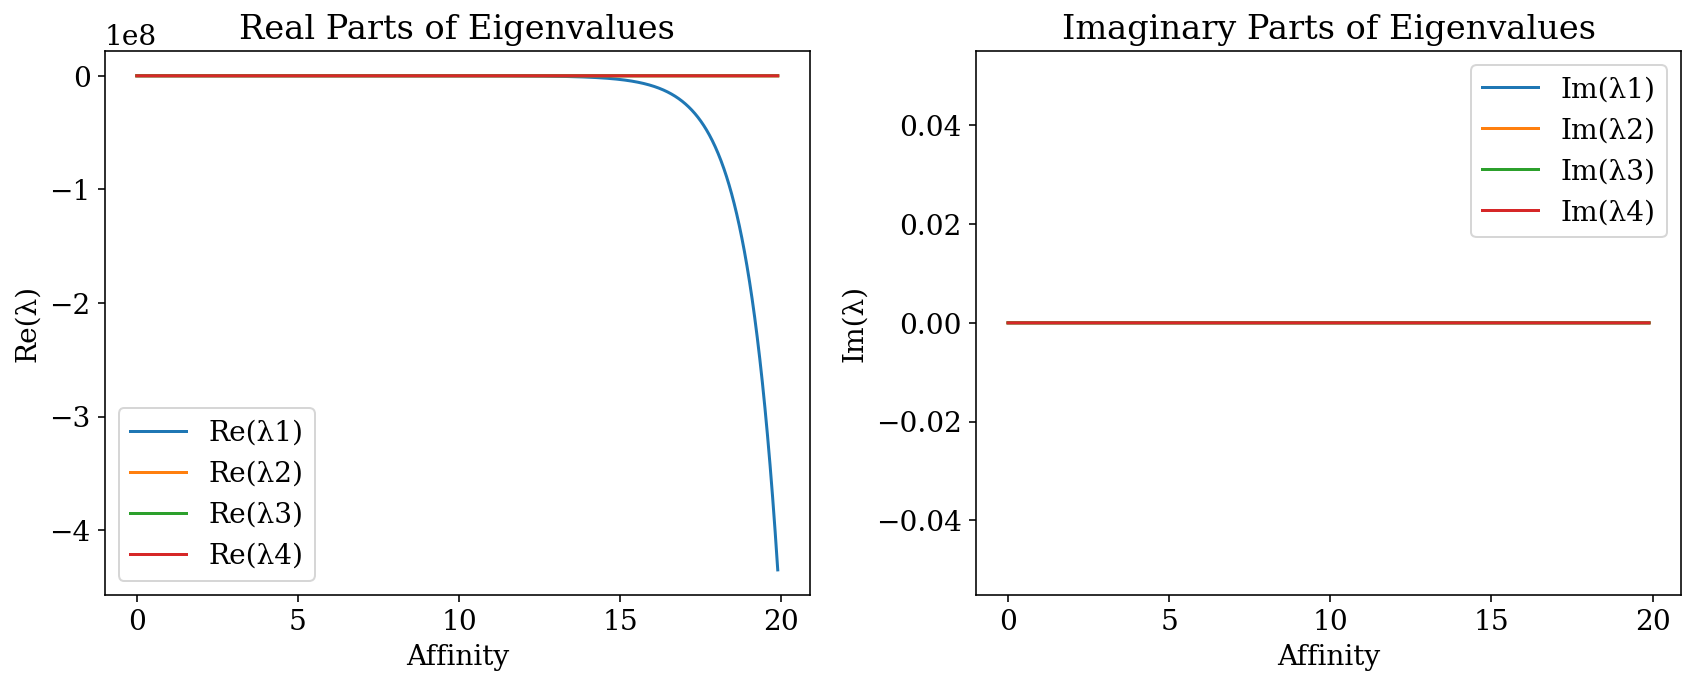

In [14]:
plt.figure(figsize=(12,5))

# Real part
plt.subplot(1,2,1)
for j in range(4):
    plt.plot(affinities, eigvals_all_r[:, j], label=f"Re(λ{j+1})")
plt.xlabel("Affinity")
plt.ylabel("Re(λ)")
plt.title("Real Parts of Eigenvalues")
plt.legend()

# Imaginary part
plt.subplot(1,2,2)
for j in range(4):
    plt.plot(affinities, eigvals_all_c[:, j], label=f"Im(λ{j+1})")
plt.xlabel("Affinity")
plt.ylabel("Im(λ)")
plt.title("Imaginary Parts of Eigenvalues")
plt.legend()

plt.tight_layout()
plt.savefig(f"eigenvalue_evolution_edge_{edge_idx}.png", dpi=300)
plt.show()


Parameter set 2: randomly generated

In [35]:
labels_f_eq, labels_r_eq = eq_params_k4()
print(labels_f_eq)
print(labels_r_eq)

labels_f_eq1 = labels_f_eq.copy()
labels_r_eq1 = labels_r_eq.copy()

aff = np.abs(np.log(np.prod(labels_f_eq)/np.prod(labels_r_eq)))
print(aff)

[163.3, 0.05286, 0.001023, 35.98]
[29.22, 3.277, 7.052, 0.00047052334916261937]
0.0


In [36]:
# k23
labels_f = labels_f_eq1.copy()
labels_r = labels_r_eq1.copy()

# autocorr settings
signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 200, num=500)

# arrays for tracking aff, area, and eigs
N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N, dtype=float)
eigvals_all_r = np.zeros((N, 4), dtype=np.float128)
eigvals_all_c = np.zeros((N, 4), dtype=np.float128)

# edge to perturb
edge_idx = 1
perturb_edge = labels_f[edge_idx] # labels_f[1] = k23

for i in tqdm(range(0,N)):
    
    labels_f[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
    areas[i] = np.abs(np.trapz(a13)-np.trapz(a31))
    
    # Track eigenvalues (real part)
    eigvals = scipy.linalg.eigvals(lap)
    eigvals_all_r[i, :] = np.sort(eigvals.real)
    eigvals_all_c[i, :] = np.sort(eigvals.imag)
    
    perturb_edge *= 1.01

np.savez(f"steinberg_edge_{edge_idx}_params2.npz", affinities=affinities, areas=areas)

100%|███████████████████████████████████████| 2000/2000 [03:10<00:00, 10.48it/s]


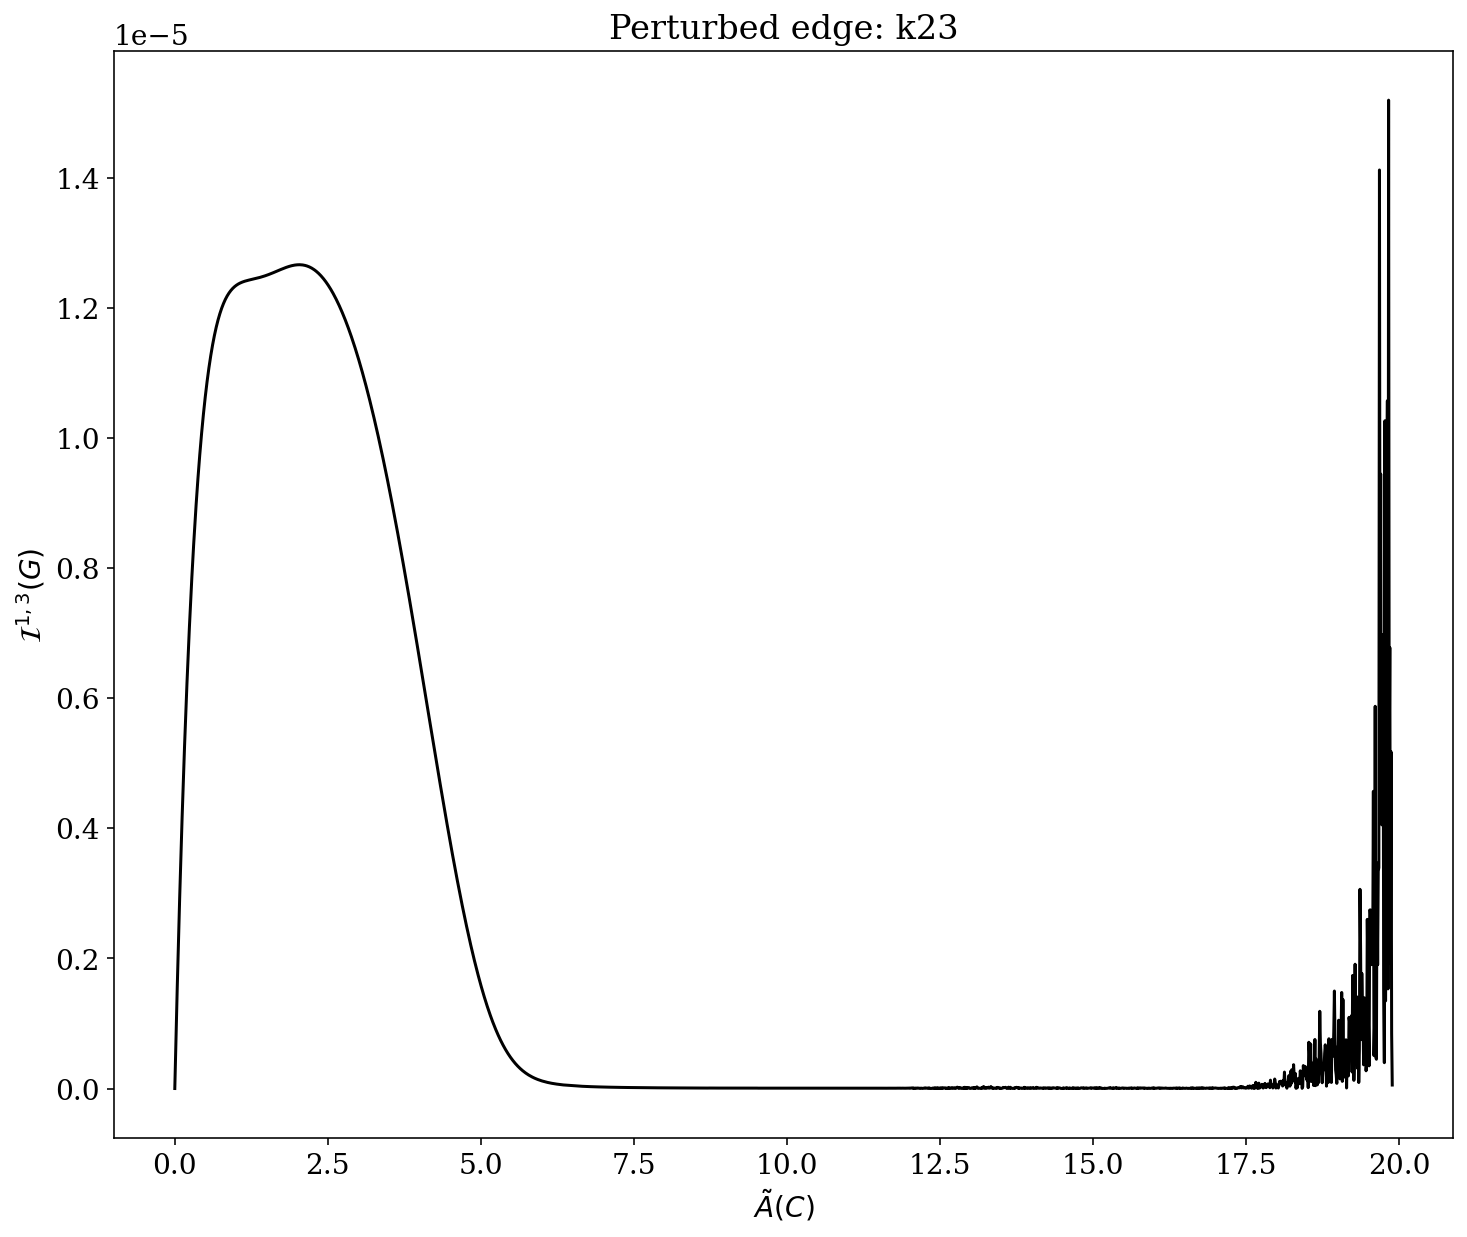

In [27]:
edge_map = {
    0: (1, 2),
    1: (2, 3),
    2: (3, 4),
    3: (4, 1)
}
src, tgt = edge_map[edge_idx]

plt.figure()
plt.plot(affinities, areas, color='black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.title(f"Perturbed edge: k{src}{tgt}")
plt.savefig(f"steinberg_curve_edge_{edge_idx}.png", dpi=300)
plt.show()

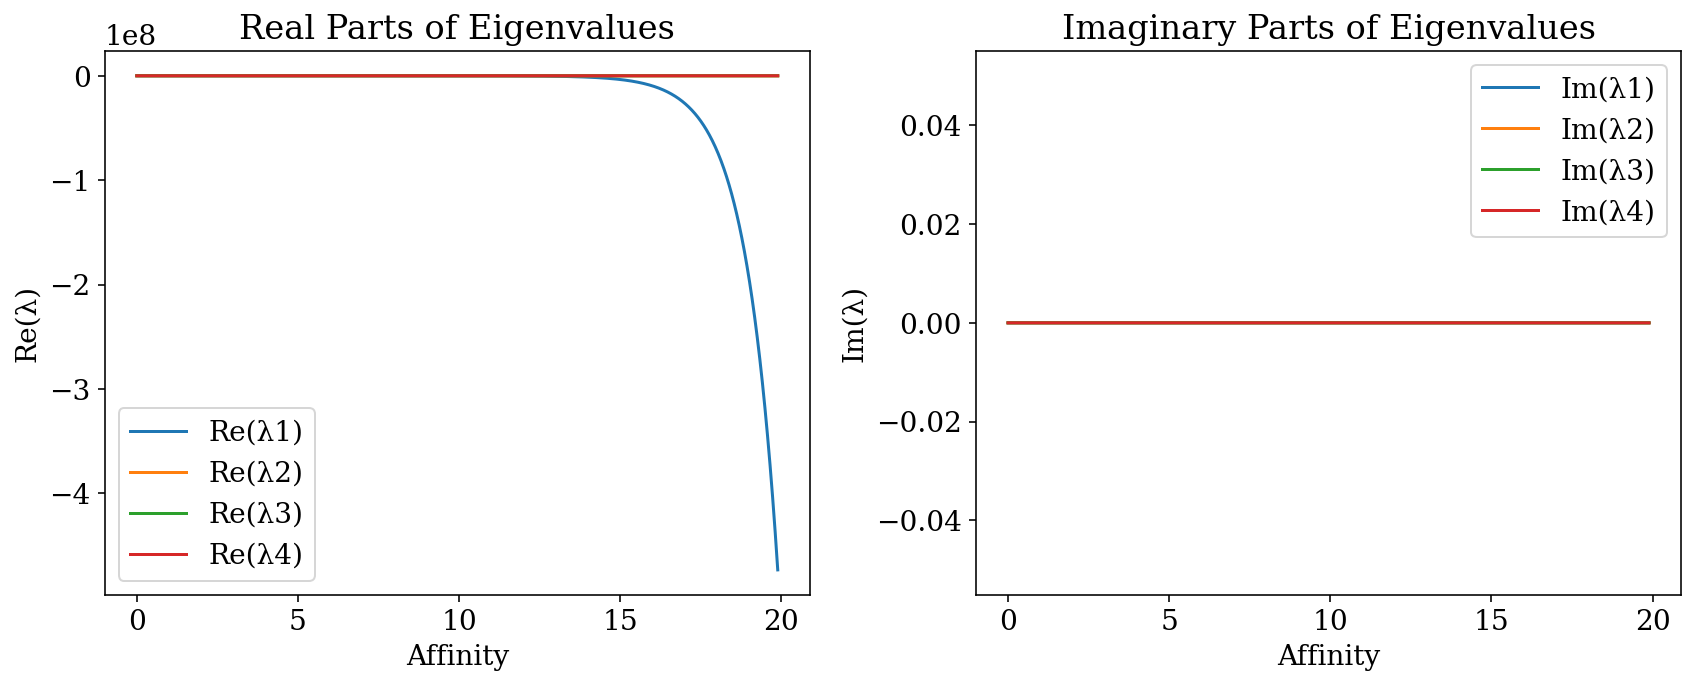

In [34]:
plt.figure(figsize=(12,5))

# Real part
plt.subplot(1,2,1)
for j in range(4):
    plt.plot(affinities, eigvals_all_r[:, j], label=f"Re(λ{j+1})")
plt.xlabel("Affinity")
plt.ylabel("Re(λ)")
plt.title("Real Parts of Eigenvalues")
plt.legend()

# Imaginary part
plt.subplot(1,2,2)
for j in range(4):
    plt.plot(affinities, eigvals_all_c[:, j], label=f"Im(λ{j+1})")
plt.xlabel("Affinity")
plt.ylabel("Im(λ)")
plt.title("Imaginary Parts of Eigenvalues")
plt.legend()

plt.tight_layout()
plt.savefig(f"eigenvalue_evolution_edge_{edge_idx}.png", dpi=300)
plt.show()


Does it matter which edge label is perturbed?

In [27]:
print(labels_f_eq)
print(labels_r_eq)
print("---")
print(labels_f_eq1)
print(labels_r_eq1)

[2.93, 12452241634.242132, 912.2, 1.411]
[108.7, 224.2, 815.9, 0.005430051699947225]
---
[2.93, 12452241634.242132, 912.2, 1.411]
[108.7, 224.2, 815.9, 0.005430051699947225]


In [10]:
#k12
labels_f = labels_f_eq1
labels_r = labels_r_eq1

signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 1000, num=500)

N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N, dtype=float)
eigvals_all_r = np.zeros((N, 4), dtype=np.float128)
eigvals_all_c = np.zeros((N, 4), dtype=np.float128)
edge_idx = 0
perturb_edge = labels_f[edge_idx] # labels_f[0] = k12

for i in tqdm(range(0,N)):
    
    labels_f[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
    areas[i] = np.abs(np.trapz(a13)-np.trapz(a31))
    
    # Track eigenvalues (real part)
    eigvals = scipy.linalg.eigvals(lap)
    eigvals_all_r[i, :] = np.sort(eigvals.real)
    eigvals_all_c[i, :] = np.sort(eigvals.imag)
    
    perturb_edge *= 1.01

np.savez(f"steinberg_edge_{edge_idx}.npz", affinities=affinities, areas=areas)

100%|███████████████████████████████████████| 2000/2000 [05:16<00:00,  6.32it/s]


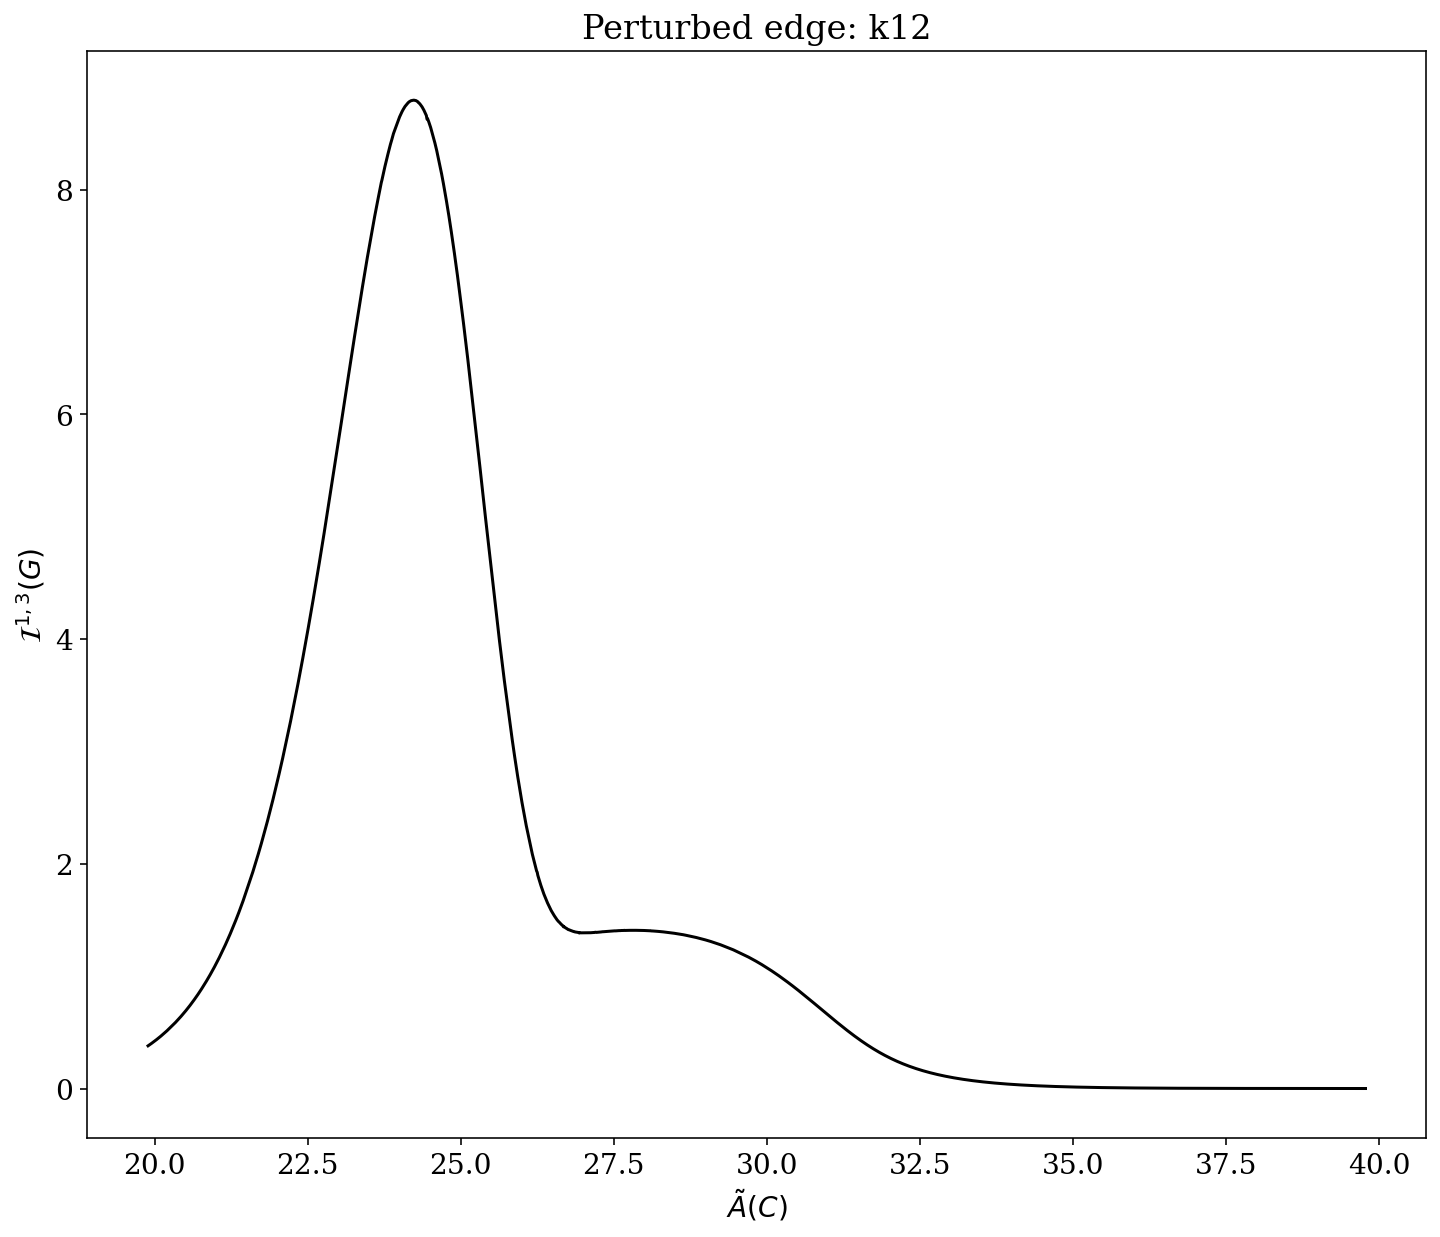

In [11]:
edge_map = {
    0: (1, 2),
    1: (2, 3),
    2: (3, 4),
    3: (4, 1)
}
src, tgt = edge_map[edge_idx]

plt.figure()
plt.plot(affinities, areas, color='black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.title(f"Perturbed edge: k{src}{tgt}")
plt.savefig(f"steinberg_curve_edge_{edge_idx}.png", dpi=300)
plt.show()

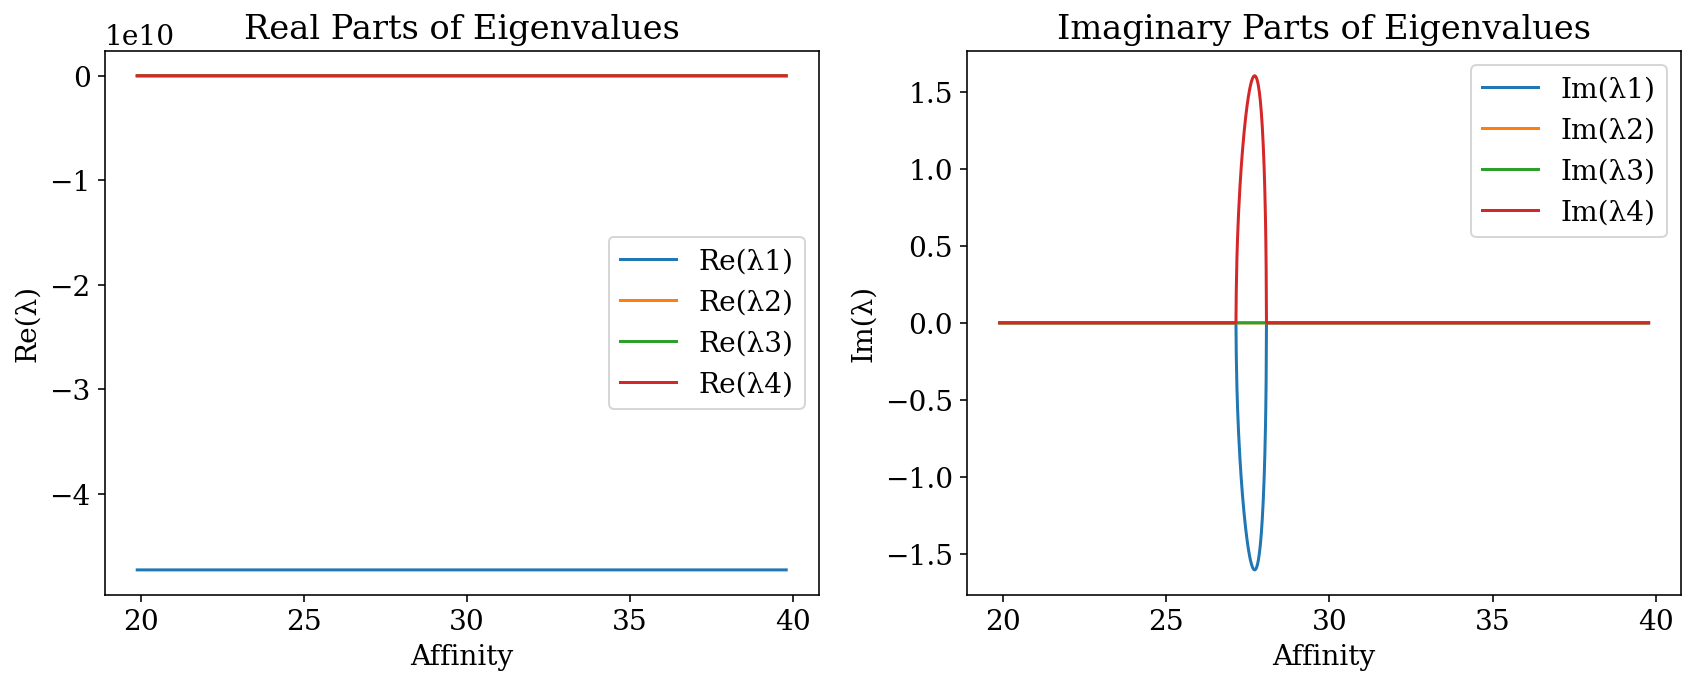

In [12]:
plt.figure(figsize=(12,5))

# Real part
plt.subplot(1,2,1)
for j in range(4):
    plt.plot(affinities, eigvals_all_r[:, j], label=f"Re(λ{j+1})")
plt.xlabel("Affinity")
plt.ylabel("Re(λ)")
plt.title("Real Parts of Eigenvalues")
plt.legend()

# Imaginary part
plt.subplot(1,2,2)
for j in range(4):
    plt.plot(affinities, eigvals_all_c[:, j], label=f"Im(λ{j+1})")
plt.xlabel("Affinity")
plt.ylabel("Im(λ)")
plt.title("Imaginary Parts of Eigenvalues")
plt.legend()

plt.tight_layout()
plt.savefig(f"eigenvalue_evolution_edge_{edge_idx}.png", dpi=300)
plt.show()

In [17]:
#k34
labels_f = [1.0, 1.0, 1.0, 1.0]
labels_r = [1.0, 1.0, 1.0, 1.0]

signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 200, num=1000)

N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N, dtype=float)
edge_idx = 2
perturb_edge = labels_f[edge_idx] # labels_f[2] = k34

for i in tqdm(range(0,N)):
    
    labels_f[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    pi = mtt_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
    areas[i] = np.abs(np.trapz(a13)-np.trapz(a31))
    
    perturb_edge *= 1.01
    
np.savez(f"steinberg_edge_{edge_idx}.npz", affinities=affinities, areas=areas)

100%|███████████████████████████████████████| 2000/2000 [09:57<00:00,  3.35it/s]


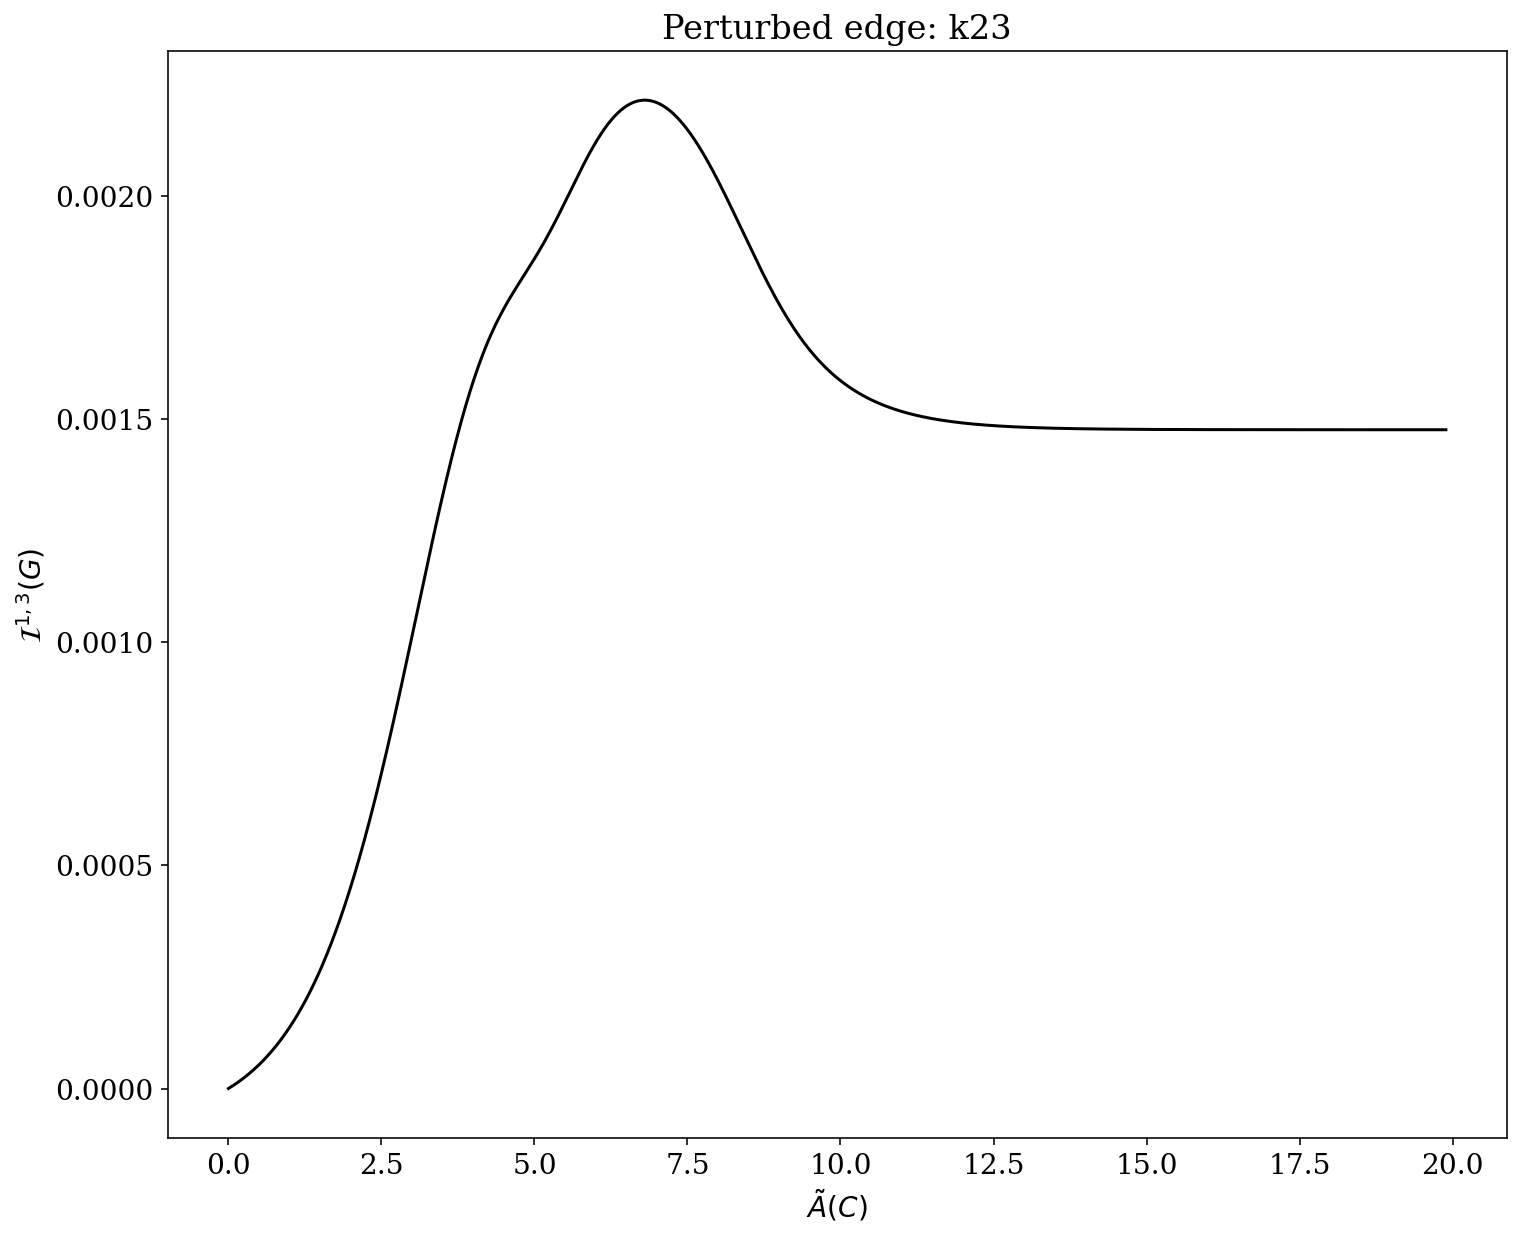

In [37]:
edge_map = {
    0: (1, 2),
    1: (2, 3),
    2: (3, 4),
    3: (4, 1)
}
src, tgt = edge_map[edge_idx]

plt.figure()
plt.plot(affinities, areas, color='black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.title(f"Perturbed edge: k{src}{tgt}")
plt.savefig(f"steinberg_curve_edge_{edge_idx}.png", dpi=300)
plt.show()

In [19]:
#k41
labels_f = [1.0, 1.0, 1.0, 1.0]
labels_r = [1.0, 1.0, 1.0, 1.0]

signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 200, num=1000)

N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N, dtype=float)
edge_idx = 3
perturb_edge = labels_f[edge_idx] # labels_f[3] = k41

for i in tqdm(range(0,N)):
    
    labels_f[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    pi = mtt_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
    areas[i] = np.abs(np.trapz(a13)-np.trapz(a31))
    
    perturb_edge *= 1.01
    
np.savez(f"steinberg_edge_{edge_idx}.npz", affinities=affinities, areas=areas)

100%|███████████████████████████████████████| 2000/2000 [09:54<00:00,  3.36it/s]


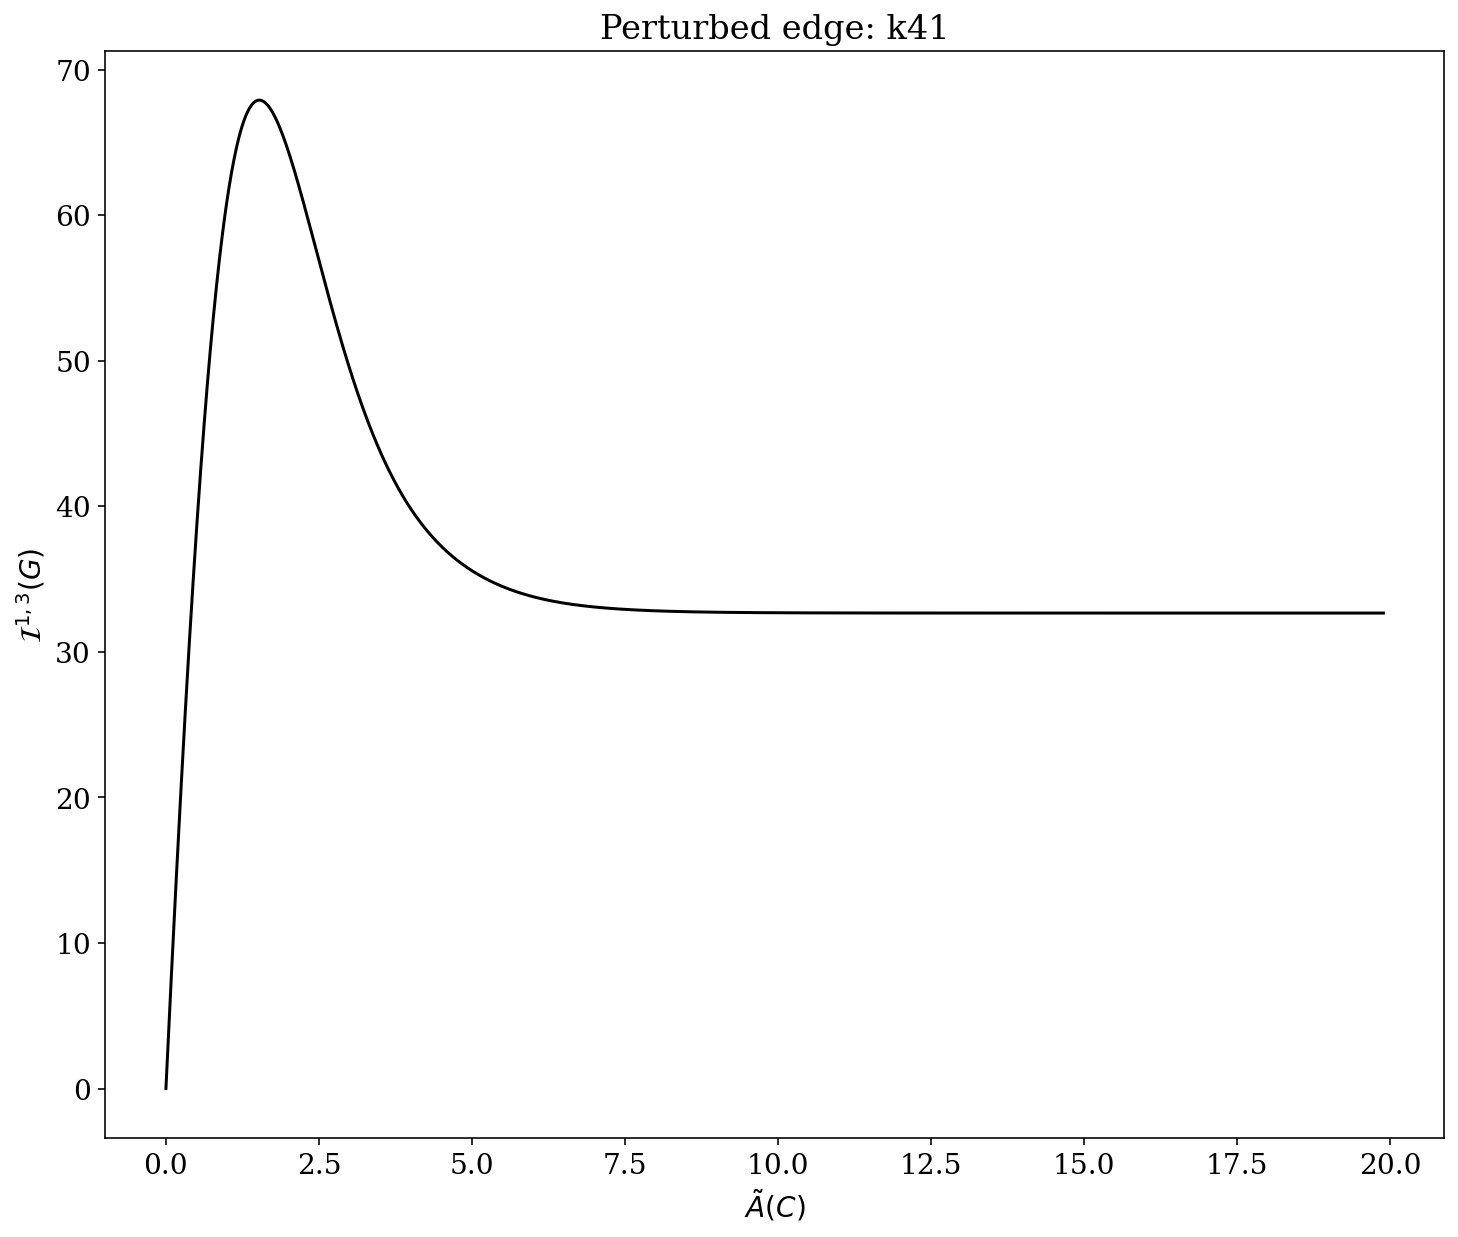

In [20]:
edge_map = {
    0: (1, 2),
    1: (2, 3),
    2: (3, 4),
    3: (4, 1)
}
src, tgt = edge_map[edge_idx]

plt.figure()
plt.plot(affinities, areas, color='black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.title(f"Perturbed edge: k{src}{tgt}")
plt.savefig(f"steinberg_curve_edge_{edge_idx}.png", dpi=300)
plt.show()

In [21]:
# k32
labels_f = [1.0, 1.0, 1.0, 1.0]
labels_r = [1.0, 1.0, 1.0, 1.0]

signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 200, num=1000)

N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N, dtype=float)
edge_idx = 1
perturb_edge = labels_r[edge_idx] # labels_r[1] = k32

for i in tqdm(range(0,N)):
    
    labels_r[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    pi = mtt_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
    areas[i] = np.abs(np.trapz(a13)-np.trapz(a31))
    
    perturb_edge *= 1.01

np.savez(f"steinberg_edge_{edge_idx}_r.npz", affinities=affinities, areas=areas)

100%|███████████████████████████████████████| 2000/2000 [06:03<00:00,  5.50it/s]


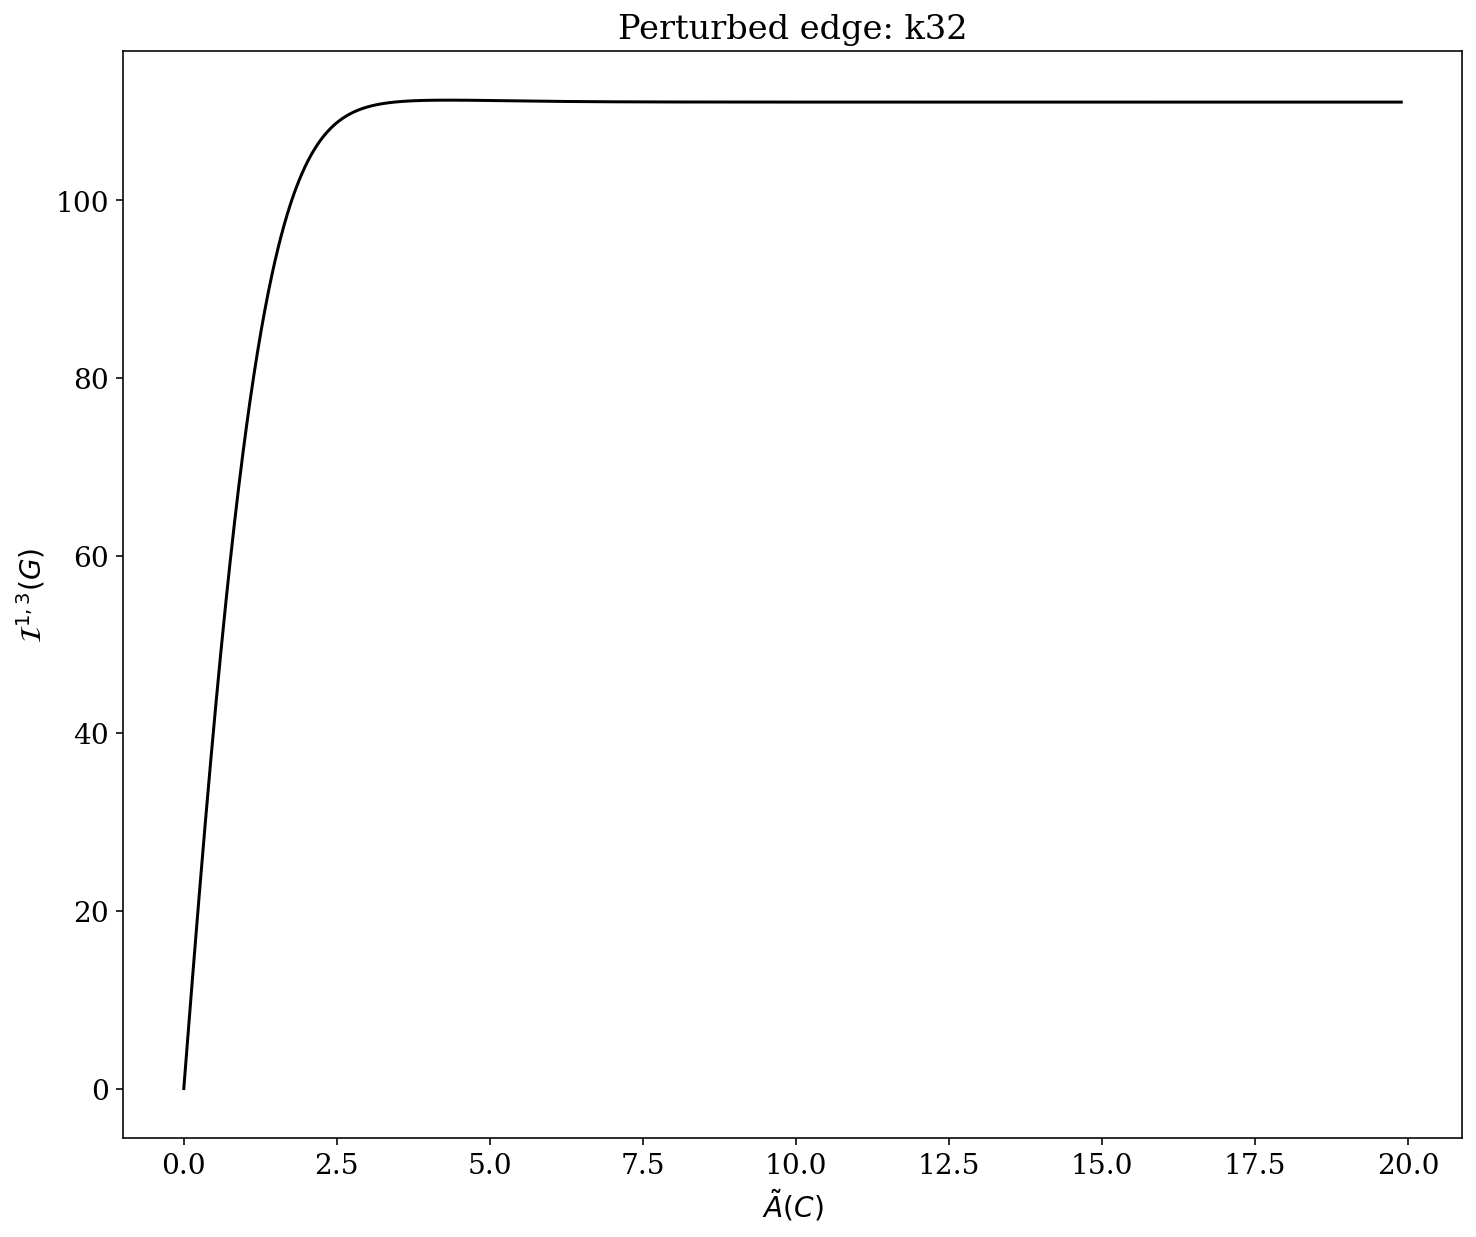

In [22]:
edge_map_rev = {
    0: (2, 1),
    1: (3, 2),
    2: (4, 3),
    3: (1, 4)
}

src, tgt = edge_map_rev[edge_idx]

plt.figure()
plt.plot(affinities, areas, color='black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.title(f"Perturbed edge: k{src}{tgt}")
plt.savefig(f"steinberg_curve_edge_{edge_idx}_r.png", dpi=300)
plt.show()

In [23]:
#k21
labels_f = [1.0, 1.0, 1.0, 1.0]
labels_r = [1.0, 1.0, 1.0, 1.0]

signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 200, num=1000)

N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N, dtype=float)
edge_idx = 0
perturb_edge = labels_r[edge_idx] # labels_r[0] = k21

for i in tqdm(range(0,N)):
    
    labels_r[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    pi = mtt_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
    areas[i] = np.abs(np.trapz(a13)-np.trapz(a31))
    
    perturb_edge *= 1.01

np.savez(f"steinberg_edge_{edge_idx}_r.npz", affinities=affinities, areas=areas)

100%|███████████████████████████████████████| 2000/2000 [06:08<00:00,  5.42it/s]


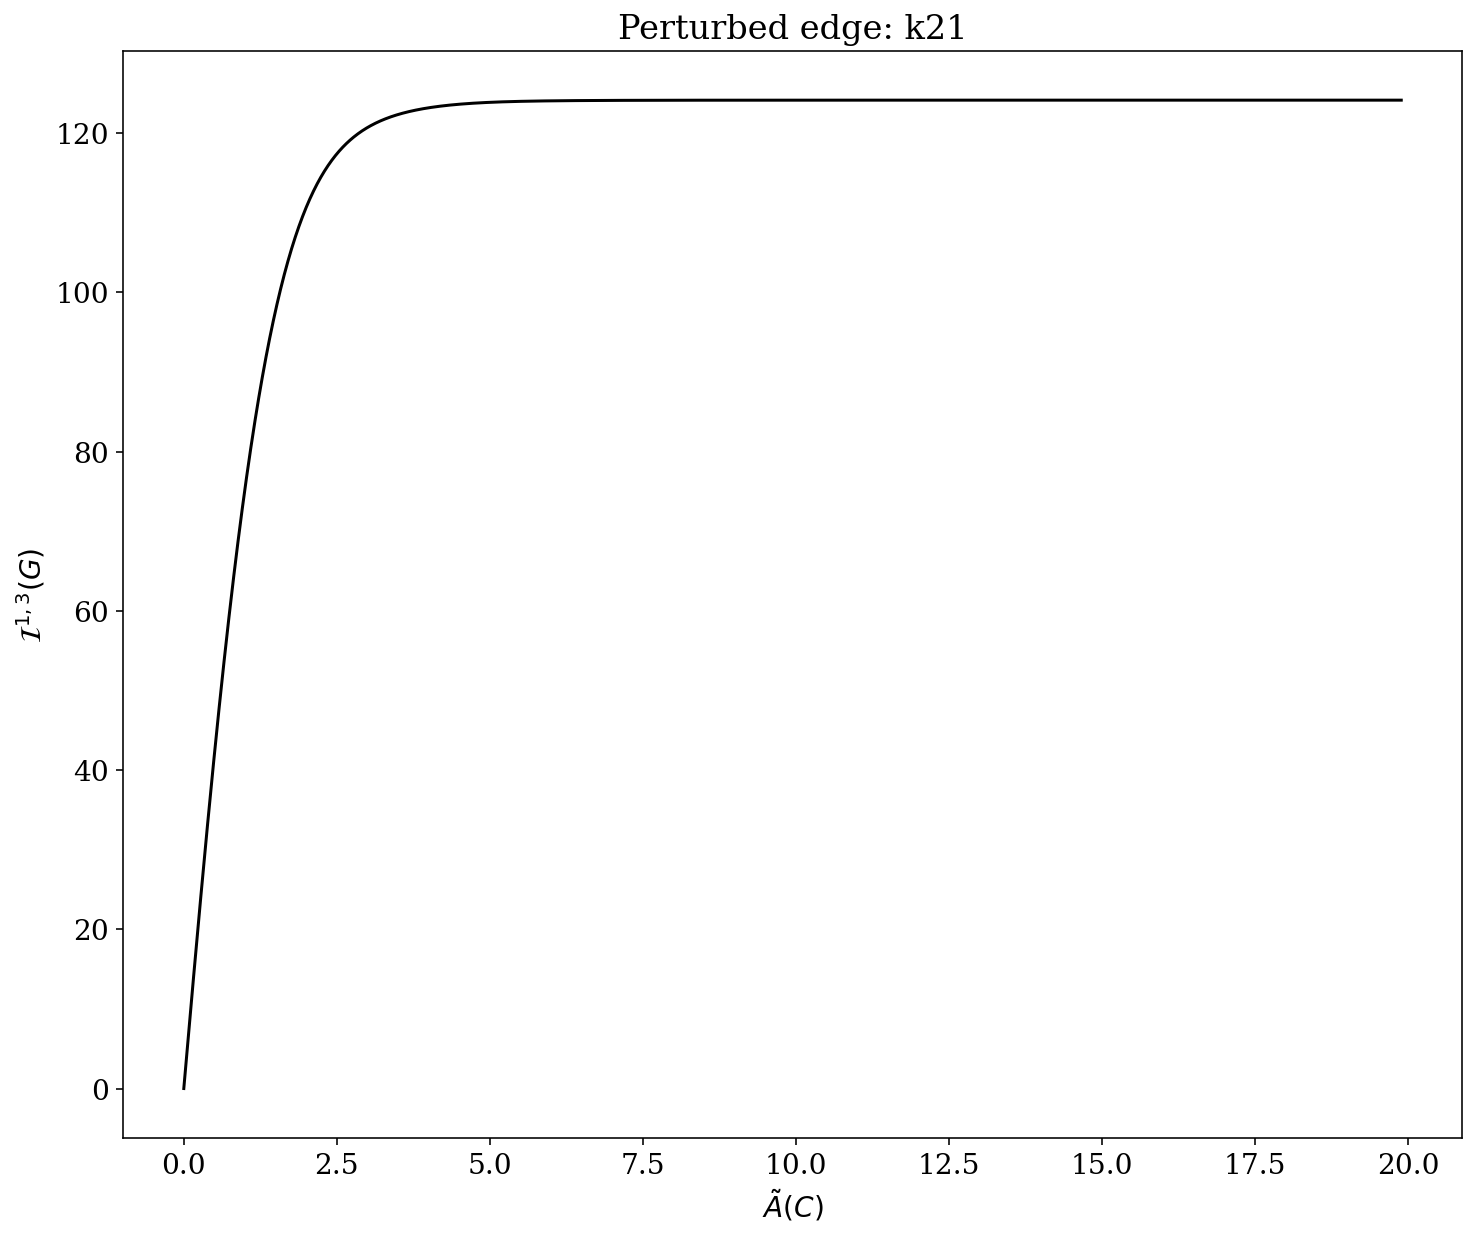

In [ ]:
edge_map_rev = {
    0: (2, 1),
    1: (3, 2),
    2: (4, 3),
    3: (1, 4)
}

src, tgt = edge_map_rev[edge_idx]

plt.figure()
plt.plot(affinities, areas, color='black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.title(f"Perturbed edge: k{src}{tgt}")
plt.savefig(f"steinberg_curve_edge_{edge_idx}_r.png", dpi=300)
plt.show()

In [25]:
#k43
labels_f = [1.0, 1.0, 1.0, 1.0]
labels_r = [1.0, 1.0, 1.0, 1.0]

signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 200, num=1000)

N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N, dtype=float)
edge_idx = 2
perturb_edge = labels_r[edge_idx] # labels_r[2] = k43

for i in tqdm(range(0,N)):
    
    labels_r[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    pi = mtt_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
    areas[i] = np.abs(np.trapz(a13)-np.trapz(a31))
    
    perturb_edge *= 1.01
    
np.savez(f"steinberg_edge_{edge_idx}_r.npz", affinities=affinities, areas=areas)

100%|███████████████████████████████████████| 2000/2000 [06:09<00:00,  5.41it/s]


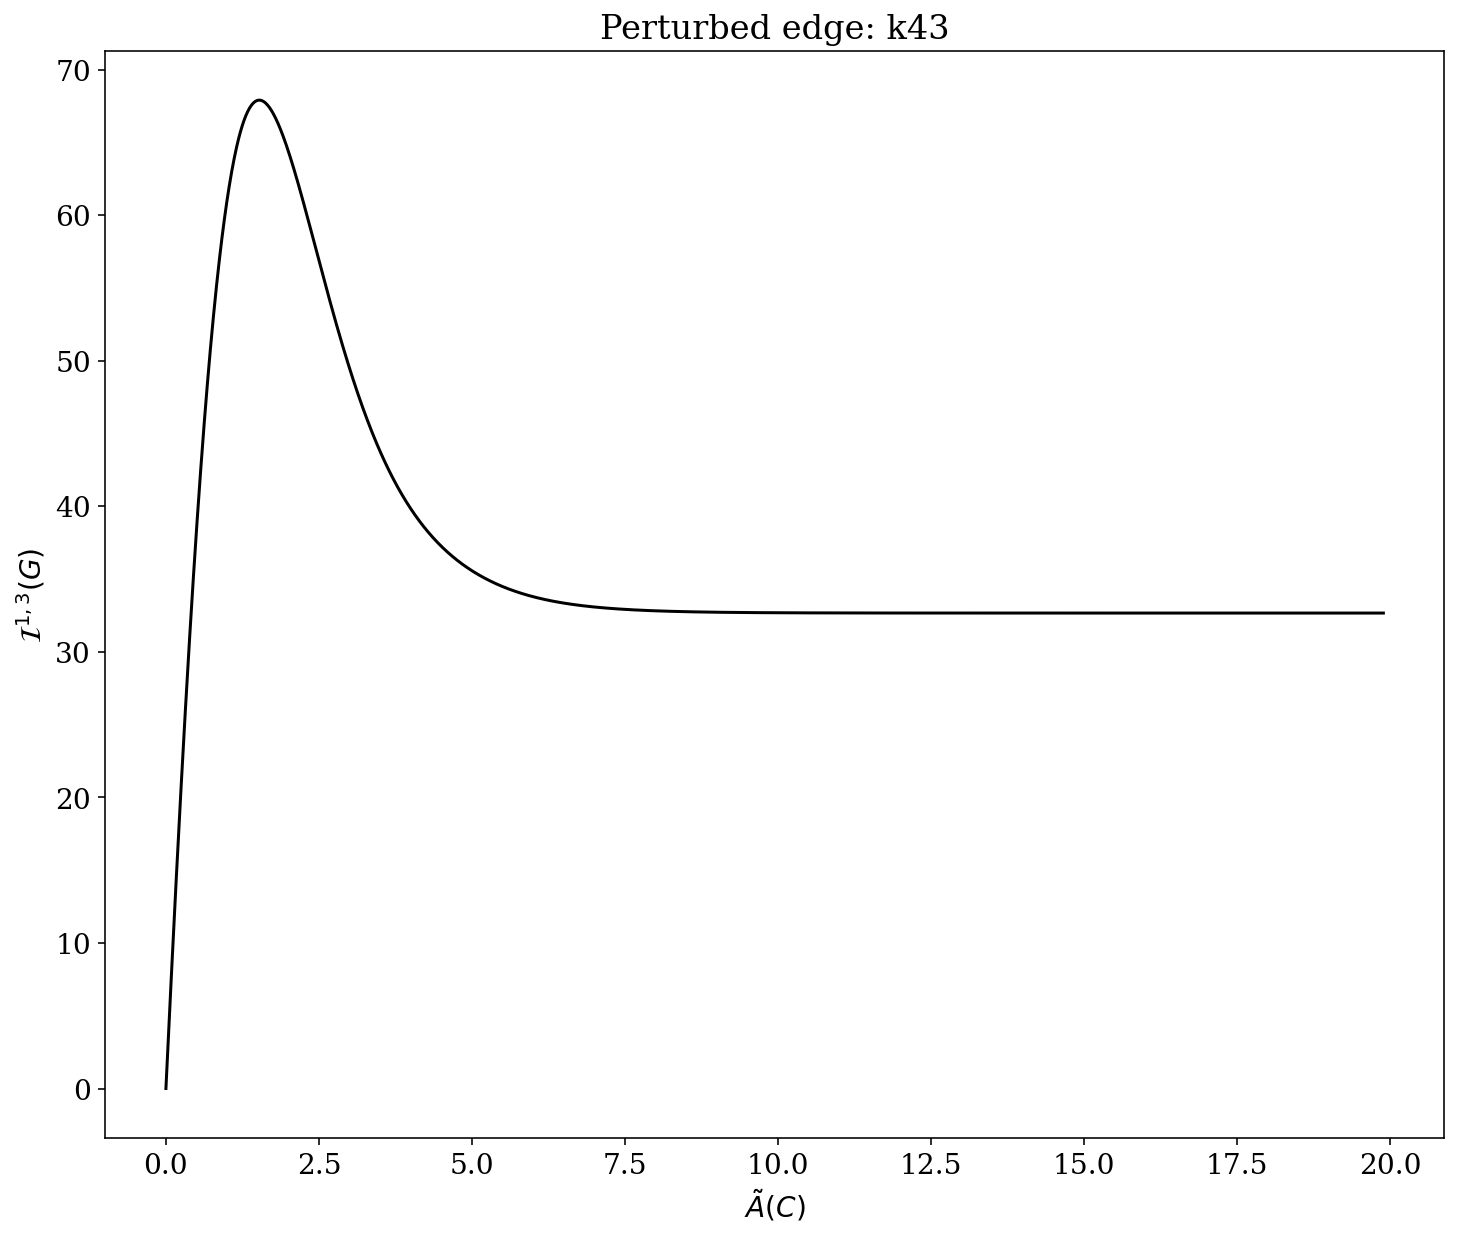

In [26]:
edge_map_rev = {
    0: (2, 1),
    1: (3, 2),
    2: (4, 3),
    3: (1, 4)
}

src, tgt = edge_map_rev[edge_idx]

plt.figure()
plt.plot(affinities, areas, color='black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.title(f"Perturbed edge: k{src}{tgt}")
plt.savefig(f"steinberg_curve_edge_{edge_idx}_r.png", dpi=300)
plt.show()

In [27]:
#k14
labels_f = [1.0, 1.0, 1.0, 1.0]
labels_r = [1.0, 1.0, 1.0, 1.0]

signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 200, num=1000)

N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N, dtype=float)
edge_idx = 3
perturb_edge = labels_r[edge_idx] # labels_r[3] = k14

for i in tqdm(range(0,N)):
    
    labels_r[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    pi = mtt_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
    areas[i] = np.abs(np.trapz(a13)-np.trapz(a31))
    
    perturb_edge *= 1.01
    
np.savez(f"steinberg_edge_{edge_idx}_r.npz", affinities=affinities, areas=areas)

100%|███████████████████████████████████████| 2000/2000 [06:18<00:00,  5.29it/s]


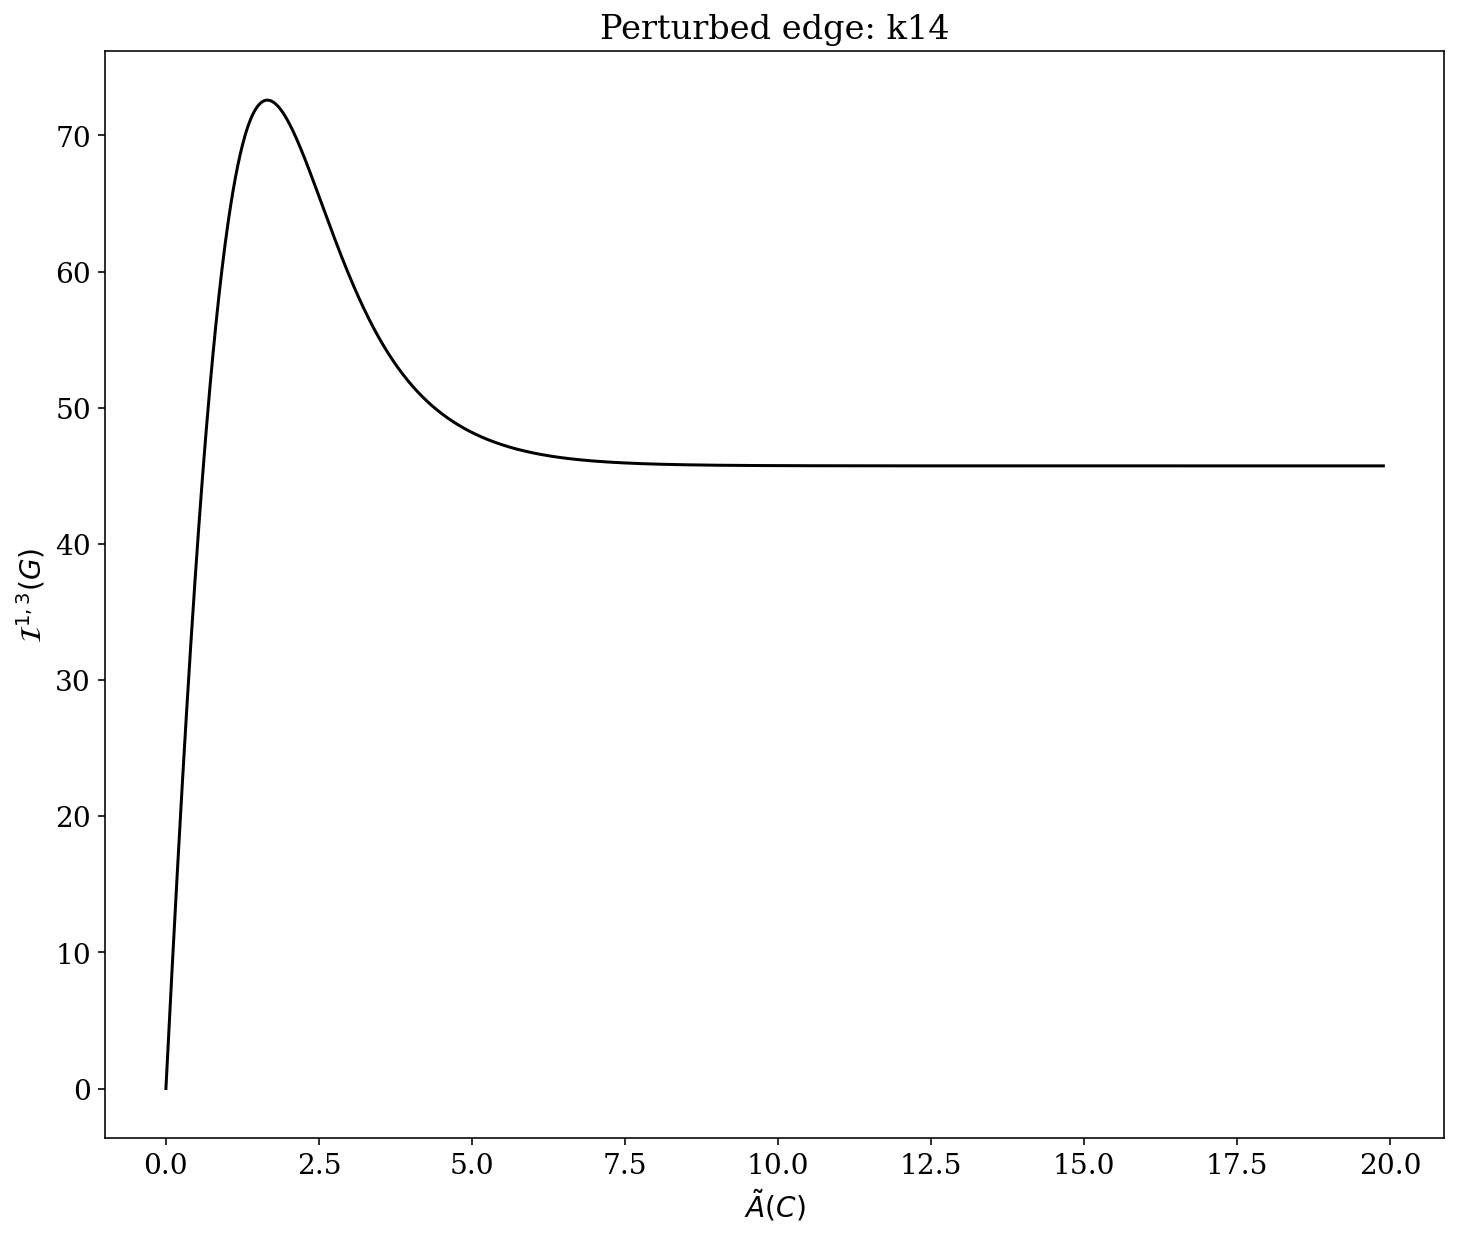

In [28]:
edge_map_rev = {
    0: (2, 1),
    1: (3, 2),
    2: (4, 3),
    3: (1, 4)
}

src, tgt = edge_map_rev[edge_idx]

plt.figure()
plt.plot(affinities, areas, color='black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.title(f"Perturbed edge: k{src}{tgt}")
plt.savefig(f"steinberg_curve_edge_{edge_idx}_r.png", dpi=300)
plt.show()